# Advanced T&E User Demonstration Notebook

This notebook walks through an advanced T&E example for an image classification task. 

1. Define the T&E task
2. Set up the dataset
3. Load the classification model
4. Scope relevant attacks
5. Execute evaluation
6. Draw conclusions on model vulnerabilities
7. Next steps

#### Notebook imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

from heart_library.estimators.classification.pytorch import JaticPyTorchClassifier
from heart_library.attacks.attack import JaticAttack
from datasets import load_dataset

from art.attacks.evasion import ProjectedGradientDescentPyTorch, FastGradientMethod, HopSkipJump, AutoAttack
from heart_library.metrics import AccuracyPerturbationMetric

%matplotlib inline

## 1. Define the image classification task
- This notebook addresses an image classification T&E task. 
- Specifically, a model has been trained to classify objects from overhead satellite imagery. 
- This model is due to be deployed, but first must undergo test and evaluation to ensure the predictions returned:
    - are trustworthy and consistent
    - are not vulnerable to virtual (noise added to the image after it has been taken) attacks
    - are not vulnerable to physical (noise or patterns physically present in the image) attacks

The classes for this task are defined below. 

In [2]:
classes = {
    0:'Building',
    1:'Construction Site',
    2:'Engineering Vehicle',
    3:'Fishing Vessel',
    4:'Oil Tanker',
    5:'Vehicle Lot'
}

## 2. Set up the dataset
- The xview dataset has been selected for this task
- The satellite images of objects have been cropped to provide an image classification dataset
- The goal is to correctly classify the objects
- The dataset is loaded using the maite ```load_dataset``` utility

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

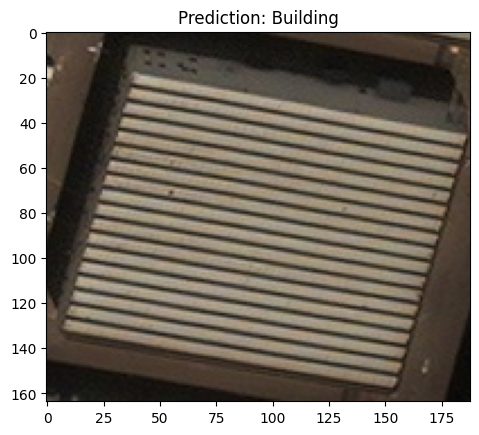

In [3]:
data = load_dataset("CDAO/xview-subset-classification", split="test[0:12]")
idx = 3
plt.title(f"Prediction: {classes[data[idx]['label']]}")
plt.imshow(data[idx]['image'])

## 3. Load the classification model
- Fine-tuned RESNET-18 is the model under inspection
- It has been adjusted to support only the 6 objects of interest defined above
- It has an accuracy of X

In [4]:
model = torchvision.models.resnet18(False)
num_ftrs = model.fc.in_features 
model.fc = torch.nn.Linear(num_ftrs, len(classes.keys())) 
model.load_state_dict(torch.load('../utils/resources/models/xview_model.pt'))
_ = model.eval()

/Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/env/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## 4. Scope relevant attacks
- In the scope of this notebook, the key attacks of interest are __evasion__ attacks
- We do not wish an adversary to block certain objects from being detected or cause misdirection by forcing the model to detect an object in a given image
- We know the model is not currently deployed and in use and is currently being refined and evaluated by numerous internal groups and external experts
- Whilst unlikely, this broader access to the model means it may be vulnerable to white-box attacks. Therefore, the following white-box attacks are considered for evaluation:
    - __Projected Gradient Descent__
        - This attack attempts to find the perturbation that maximizes the loss of a model on a particular input while keeping the size of the perturbation smaller than epsilon, a budget.
        - Parameters:
            - _eps_: maximum perturbation an attacker can introduce
            - _eps_step_: input variation at each iteration
            - _max_iter_: the maximum number of iterations
            - _targeted_: whether the attack is targeted or not
    - __Carlini & Wagner__
        - This attack attempts to find the smallest perturbation added to an image that changes the classification. 
        - Parameters:
            - _confidence_: higher value produces adversarial examples that are less simlar to the original input, but result in a higher confidence
            - _learning_rate_: learning rate for attack algorithn, smaller values introduce better results, but slower
            - _targeted_: whether the attack is targeted or not
    - __Fast Gradient Method__
        - Parameters:
            - _eps_: maximum perturbation an attacker can introduce
            - _eps_step_: input variation at each iteration
            - _minimal_: indicate if wish to compute the minimal perturbation
            - _targeted_: whether the attack is targeted or not
        - This attack
- In addition, when the model is deployed, it will be made accessible via API to certain parties. Whilst model internals will not be exposed, output of the model will be returned which could be used to launch black-box attacks. Therefore, the following black-box attacks are considered for evaluation:
    - __HopSkipJump__
        - A black-box attack that uses the predictions output from a model to guide the search for an input variation that produces a misclassification
        - Parameters:
            - _eps_step_: input variation at each iteration
            - _max_iter_: the maximum number of iterations
            - _targeted_: whether the attack is targeted or not

__In the scope of this T&E task, 6 white-box and 6 black-box attacks have been selected for evaluating the vulnerability of the RESNET-18 image classification model when identifying 6 objects in satellite imagery__. 

Each attack has a number of parameters to consider which impacts the effectiveness of the launched attack and conclusions drawn regarding efficacy and likelihood.  

## 5. Execute Evaluation
Now that the scope of the task is determined and relevant attacks identified, the first step of evaluation can be executed. The use of ```maite``` expedites this process. To carry out:
- wrap the classifier in a supported class ```JaticPyTorchClassifier```
- ensure the dataset conforms to the correct dimensions for the model and in a format expected by the __maite protocols__
- define the attacks and wrap using the supported class ```JaticAttack``` 
- generate adversarial images from attacks by executing the ```run_attack``` method for each attack
- collect the clean and robust accuracy for each attack to detmerine the success of the attacks and the vulnerability of the model

In [5]:
'''
Wrap the model
'''
jptc = JaticPyTorchClassifier(
    model=model, loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1)
)

'''
Transform dataset
'''
IMAGE_H, IMAGE_W = 224, 224
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize((IMAGE_H, IMAGE_W)),
    transforms.ToTensor()
])

data = data.map(lambda x: {"image": preprocess(x["image"]), "label": x["label"]})
to_image = lambda x: transforms.ToPILImage()(torch.Tensor(x))


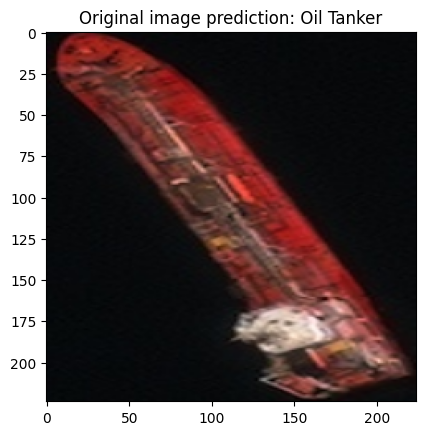

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

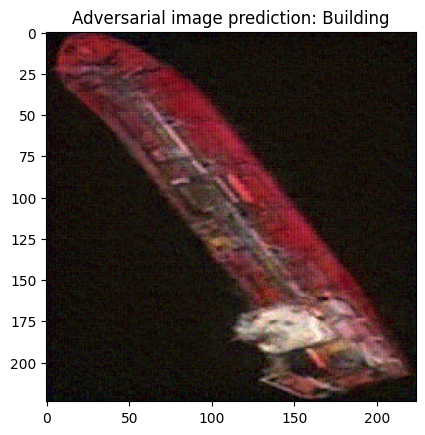

clean accuracy: 1.0
robust accuracy: 0.0
perturbation: 19.48211669921875


In [6]:
sample_data = torch.utils.data.Subset(data, [11])

'''
Original prediction
'''
plt.imshow(to_image(sample_data[0]["image"]))
_ = plt.title(f'Original image prediction: {list(classes.values())[np.argmax(jptc(sample_data)[0])]}')
plt.show()

'''
Define and wrap the attacks
'''
evasion_attack = ProjectedGradientDescentPyTorch(estimator=jptc, max_iter=10, eps=.1, eps_step=0.01)
# Try switching to one of the following attacks and compare results
# evasion_attack = FastGradientMethod(estimator=jptc, eps_step=0.001)
# evasion_attack = HopSkipJump(classifier=jptc, max_iter=5, max_eval=5, init_eval=1)

attack = JaticAttack(evasion_attack, norm=2)

'''
Generate adversarial images
'''
x_adv, y, metadata = attack(data=sample_data)


'''
Calc clean and robust accuracy
'''
metric = AccuracyPerturbationMetric(jptc(sample_data), metadata)
metric.update(jptc(x_adv), y)
result = metric.compute()

plt.imshow(x_adv[0][0].transpose(1,2,0))
_ = plt.title(f'Adversarial image prediction: {list(classes.values())[np.argmax(jptc(x_adv)[0])]}')
plt.show()

print(f'clean accuracy: {result["clean_accuracy"]}\nrobust accuracy: {result["robust_accuracy"]}\nperturbation: {result["mean_delta"]}')


- In the above demonstration, a single image was passed to a Projected Gradient Descent white-box attack.
- An adversarial image was generated and shown to be effective at reducing the accuracy of the model to 0 with perturbation levels that may escape human detection (notice how the original and adversarial image are hard to differentiate.)

### Feature Adversary attack

This attack requires a slight modification to our dataset format. During this attack, instead of maximizing the loss between predicted label and groundtruth label, the attack uses a __guide image__ (which has a different groundtruth label) to add noise which shifts the internal representation of the attacked image in the model to the representation of the guide image, thus optimizing for misclassification. 

To achieve this, both x and y values returned by __get_item__ are images. In the naive example below, the guide image is either the following image in the sequence of images, or the previous image. 

In [7]:
from typing import List, Dict, Any, Tuple
class ImageDataset:
    """
    MAITE aligned dataset
    """
    def __init__(self, data):
        self.images = np.asarray(data['image']).astype(np.float32)
    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, ind: int) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
        if ind+1 < len(self.images):
            y = self.images[ind+1]
        else:
            y = self.images[ind-1]
        return self.images[ind], y, {}

fa_data = ImageDataset(data)
fa_sample = torch.utils.data.Subset(fa_data, [9])

from art.attacks.evasion import FeatureAdversariesPyTorch
from heart_library.attacks.attack import JaticAttack

evasion_attack = FeatureAdversariesPyTorch(
    jptc,
    layer="fc",
    delta=0.08,
    optimizer=None,
    step_size=0.01,
    max_iter=500,
)
attack = JaticAttack(evasion_attack, norm=2)

x_adv, _, metadata = attack(fa_sample)

Feature Adversaries PyTorch:   0%|          | 0/500 [00:00<?, ?it/s]

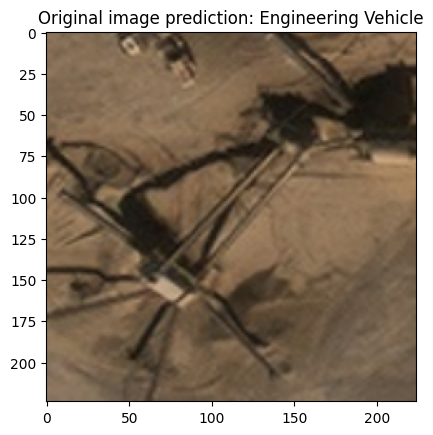

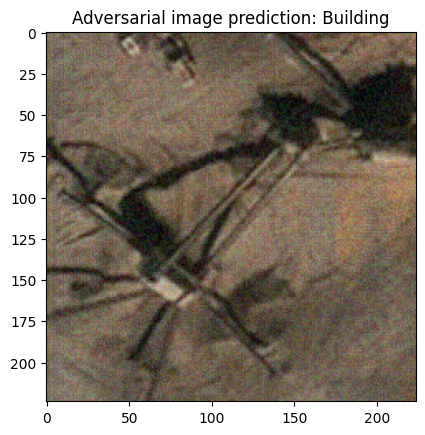

clean accuracy: 1.0
robust accuracy: 0.0
perturbation: 21.330406188964844


In [10]:
'''
Original prediction
'''
plt.imshow(to_image(fa_sample[0][0]))
_ = plt.title(f'Original image prediction: {list(classes.values())[np.argmax(jptc(fa_sample)[0][0])]}')
plt.show()

'''
Calc clean and robust accuracy
'''
metric = AccuracyPerturbationMetric(jptc(fa_sample), metadata)
metric.update(jptc(x_adv), np.array([data[9]['label']]))
result = metric.compute()

plt.imshow(x_adv[0][0].transpose(1,2,0))
_ = plt.title(f'Adversarial image prediction: {list(classes.values())[np.argmax(jptc(x_adv)[0][0])]}')
plt.show()

print(f'clean accuracy: {result["clean_accuracy"]}\nrobust accuracy: {result["robust_accuracy"]}\nperturbation: {result["mean_delta"]}')

## Scale the evaluation
The previous demonstration showed how to execute the evaluation for a white-box evasion attack. The attack type may be swapped out to include any other type of evasion attack. 

For example, by changing..
```python 
evasion_attack = ProjectedGradientDescentPyTorch(estimator=jptc, 
                                            max_iter=10,
                                            eps=.1,
                                            eps_step=0.01)
```
..to the __Carlini Wagner__ attack:
```python
evasion_attack = FastGradientMethod(estimator=jptc, eps_step=0.001)
```
..or the _black-box_ __HopSkipJump__ attack
```python
evasion_attack = HopSkipJump(classifier=jptc, max_iter=5, max_eval=5, init_eval=1)
```               
..additional attack evaluations may be executed and the vulnerability of the model to each recorded.

Alternatively, AutoAttack may be used to expedite the process. 

In [11]:
attack_1 = ProjectedGradientDescentPyTorch(estimator=jptc, max_iter=10, eps=.1, eps_step=0.01)
attack_2 = FastGradientMethod(estimator=jptc, eps_step=0.001)
attack_3 = HopSkipJump(classifier=jptc, max_iter=5, max_eval=5, init_eval=1)
attacks = [attack_1, attack_2, attack_3]
attack = JaticAttack(AutoAttack(estimator=jptc, attacks=attacks, targeted=False, parallel=False), norm=2)
adv_x, y, metadata = attack(sample_data)

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

- When AutoAttack is executed, it iterates over each attack for each image and identifies the strongest attack (most successful with least perturbation added)
- We can print the metadata associated with the best attack for each image by: ```python print(attack.attack)```
- We can also print the clean and robust accuracy metric as before

In [12]:
print(attack._attack)
print('--------')
metric = AccuracyPerturbationMetric(jptc(sample_data), metadata)
metric.update(jptc(adv_x), y)
result = metric.compute()
print(f'clean accuracy: {result["clean_accuracy"]}\nrobust accuracy: {result["robust_accuracy"]}\nperturbation: {result["mean_delta"]}')

AutoAttack(targeted=False, parallel=False, num_attacks=3)
BestAttacks:
image 1: ProjectedGradientDescentPyTorch(norm=inf, eps=0.1, eps_step=0.01, targeted=False, num_random_init=0, batch_size=32, minimal=False, summary_writer=None, decay=None, max_iter=10, random_eps=False, verbose=True, )
--------
clean accuracy: 1.0
robust accuracy: 0.0
perturbation: 19.48211669921875


- Running the attack in parallel can speed up the evaluation when many attacks/images are being examined (e.g. when varying parameters of the attacks)
- Including targeted attacks facilitates each attack to be also run in targeted mode for each classification label, meaning more attacks are evaluated and potentially stronger attacks can be discovered

#### Vary the hyperparameters (intutive)
Note: 
- set ```n = 20``` to increase the number of attacks with a variety of different hyperparameters
- set ```parallel=True``` to run the attacks in parallel


In [13]:
n = 2
attacks = []
max_iter = [i+1 for i in list(range(n))]
eps_steps = [round(float(i/100+0.001), 3) for i in list(range(n))]
for i, eps_step in enumerate(eps_steps):
    attacks.append(
        ProjectedGradientDescentPyTorch(
            estimator=jptc,
            eps=0.1,
            eps_step=eps_step,
        )
    )
    attacks.append(
        ProjectedGradientDescentPyTorch(
            estimator=jptc,
            eps=0.1,
            max_iter=max_iter[i],
        )
    )
print('Number of attacks', len(attacks))

attack = JaticAttack(AutoAttack(estimator=jptc, attacks=attacks, targeted=True, parallel=False), norm=2)
adv_x, y, metadata = attack(sample_data)

Number of attacks 4


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

- note that the best selected attack (one which is effective with least perturbation) is PGD with an _eps_step_ of __0.001__ and _max_iteration_ of __100__

In [14]:
print(attack._attack)
print('---')
metric = AccuracyPerturbationMetric(jptc(sample_data), metadata)
metric.update(jptc(adv_x), y)
result = metric.compute()
print(f'clean accuracy: {result["clean_accuracy"]}\nrobust accuracy: {result["robust_accuracy"]}\nperturbation: {result["mean_delta"]}')

AutoAttack(targeted=True, parallel=False, num_attacks=4)
BestAttacks:
image 1: ProjectedGradientDescentPyTorch(norm=inf, eps=0.1, eps_step=0.001, targeted=True, num_random_init=0, batch_size=32, minimal=False, summary_writer=None, decay=None, max_iter=100, random_eps=False, verbose=True, )
---
clean accuracy: 1.0
robust accuracy: 0.0
perturbation: 19.626998901367188


#### Execute on batch of images
To execute on a batch of images, simply:
-  add an 'image' key to a dict with the array of images in format ```[batch_size, channels, height, width]```
- add a 'label' key to the dict with the array of labels in format ```[batch_size, label]``` (note: label may be an integer or a one-hot encoded array)
- note that when printing the attack metadata, AutoAttack has identified different attacks being most effective for different images __and__ provides the parameters which achieved the best result

In [15]:
sample_data = torch.utils.data.Subset(data, [0, 3, 5, 9, 11,])

attack = JaticAttack(AutoAttack(estimator=jptc, targeted=False, parallel=True))
x_adv, y, metadata = attack(sample_data, norm=2)

AutoPGD - batch:   0%|          | 0/1 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/1 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   1%|          | 1/100 [00:00<01:05,  1.50it/s]

AutoPGD - iteration:   1%|          | 1/100 [00:00<01:06,  1.48it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]:01<00:59,  1.64it/s]

AutoPGD - iteration:   2%|▏         | 2/100 [00:01<01:01,  1.60it/s]

SquareAttack - restarts:   0%|          | 0/5 [00:00<?, ?it/s]9it/s]

AutoPGD - iteration:   3%|▎         | 3/100 [00:01<01:00,  1.60it/s]

SquareAttack - iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 1/5000 [00:00<41:59,  1.98it/s]

SquareAttack - restarts:  20%|██        | 1/5 [00:01<00:04,  1.17s/it]     

SquareAttack - restarts:  20%|██        | 1/5 [00:01<00:05,  1.35s/it]A


AutoPGD - iteration:   6%|▌         | 6/100 [00:03<00:59,  1.57it/s]

AutoPGD - iteration:   6%|▌         | 6

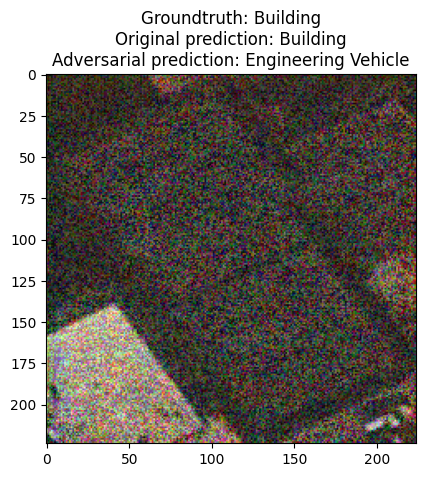

In [17]:
benign_preds = jptc(sample_data)[0]
adv_preds = jptc(x_adv)[0]

for i, adv_im in enumerate(x_adv):

       plt.imshow(adv_im[0].transpose(1,2,0))
       _ = plt.title(f'''Groundtruth: {classes[sample_data[i]['label']]}\nOriginal prediction: {list(classes.values())[np.argmax(benign_preds[i])]}\nAdversarial prediction: {list(classes.values())[np.argmax(adv_preds[i])]}''')
       plt.show()

In [18]:
print(attack._attack)

AutoAttack(targeted=False, parallel=True, num_attacks=4)
BestAttacks:
image 1: AutoProjectedGradientDescent(norm=inf, eps=0.3, eps_step=0.1, max_iter=100, targeted=False, nb_random_init=5, batch_size=32, loss_type=difference_logits_ratio, verbose=True, )
image 2: AutoProjectedGradientDescent(norm=inf, eps=0.3, eps_step=0.1, max_iter=100, targeted=False, nb_random_init=5, batch_size=32, loss_type=difference_logits_ratio, verbose=True, )
image 3: DeepFool(max_iter=100, epsilon=0.001, nb_grads=10, batch_size=32, verbose=True, )
image 4: DeepFool(max_iter=100, epsilon=0.001, nb_grads=10, batch_size=32, verbose=True, )
image 5: DeepFool(max_iter=100, epsilon=0.001, nb_grads=10, batch_size=32, verbose=True, )


## 6. Draw conclusions 
The following conclusions may be drawn after executing white and black-box attacks on the RESNET-18 model:
- All attacks can produce adversarial images which the model is vulnerable to (robust accuracy = 0%)
- PGD is the most dangerous attack as it creates adversarial images with the lowest perturbation (19.45) that should escape human detection and may escape machine detection
- Although PGD is the most successful attack, it requires full access to the model, which is an unlikely scenario unless the model is exposed
- Black-box attacks are also effective against the model and are more likely to occur if the model is deployed, but require much higher levels of perturbation to be effective, which results in a greater likelihood of detection

Additional questions that should be explored:
- for a successful black-box attack, a query budget of X is required
- classes Y are more vulnerable to adversarial attack than those remaining

## 7. Next Steps
- Modify this notebook by swapping in your own dataset and classification model
- Identify, for each image in your dataset, which type of attacks are effective (i.e. they reduce the robust accuracy)
- Identify, for each image in your dataset, which attack is strongest (i.e. it causes the model to misclassify the image __and__ has lowest perturbation)
- Identify, for each iamge in your dataset, the subsequent resources associated with the attacks identified from the previous two points
    - Were white-box or black-box attacks more effective?
    - How long did it take to retrieve an adversarial image?
    - How many times would an attacker have to query the model (in the case of black-box attacks) in order to obtain an adversarial image?
    - What are the minimum computing resources an attacker might need to deploy an attack on this model?
- Idenfity, across all images in your dataset, which classes are more vulnerable to adversarial attack? 
- Consolidate all findings into a model card for reporting